## Colab

In [1]:
!pip install comet_ml
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install contextualSpellCheck

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
# os.chdir("/content/gdrive/My Drive/SSNElab15")
os.chdir("/content/gdrive/My Drive/Colab Notebooks/SSNE_colab/miniprojekt6")

# Imports

In [4]:
import comet_ml
from comet_ml import Experiment
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt

In [5]:
import transformers
from transformers import *
import numpy as np
from datasets import load_dataset
import evaluate
from tqdm import tqdm

comet_ml is installed but `COMET_API_KEY` is not set.
/usr/local/lib/python3.8/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [6]:
from datasets import load_dataset
import datasets

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 29 19:27:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |   1172MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
RANDOM_SEED = 42
VALIDATION_PERCENTAGE = 10
# PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
# PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
PRE_TRAINED_MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

# Load and prepare data

In [10]:
full_train_dataset = load_dataset("csv", data_files="p6/train_data.csv")

train_dataset, valid_dataset = datasets.load_dataset("csv", data_files="p6/train_data.csv", split=[
    datasets.ReadInstruction('train', to=100-VALIDATION_PERCENTAGE, unit='%'),
    datasets.ReadInstruction('train', from_=-VALIDATION_PERCENTAGE, unit='%'),
])

test_dataset = load_dataset("csv", data_files="p6/test_data.csv", column_names=['review'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# rename label column
full_train_dataset = full_train_dataset.rename_column('rating', 'label')
train_dataset = train_dataset.rename_column('rating', 'label')
valid_dataset = valid_dataset.rename_column('rating', 'label')

In [12]:
print(full_train_dataset)

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 16392
    })
})


In [13]:
print(train_dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 14753
})


In [14]:
print(valid_dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 1639
})


In [15]:
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['review'],
        num_rows: 4099
    })
})


(array([1137.,    0., 1434.,    0.,    0., 1747.,    0., 4831.,    0.,
        7243.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

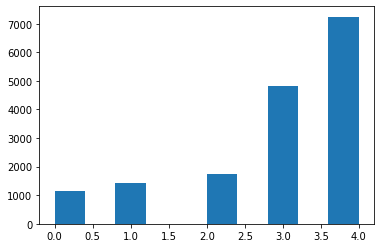

In [16]:
plt.hist(full_train_dataset['train']['label'])

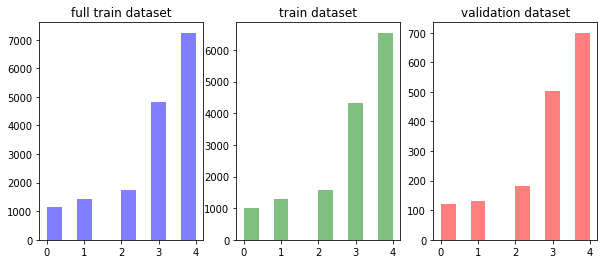

In [17]:
# Create a 3x1 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(10,4))

# Plot the first histogram in the first subplot
axs[0].hist(full_train_dataset['train']['label'], color='blue', alpha=0.5)
axs[0].set_title('full train dataset')

# Plot the second histogram in the second subplot
axs[1].hist(train_dataset['label'], color='green', alpha=0.5)
axs[1].set_title('train dataset')

# Plot the third histogram in the third subplot
axs[2].hist(valid_dataset['label'], color='red', alpha=0.5)
axs[2].set_title('validation dataset')

plt.show()

## Fixing typos

In [18]:
# https://spacy.io/universe/project/contextualSpellCheck
# # comment this cell out if you don't want to train, evaluate and predict on data with fixed typos
# import spacy
# import contextualSpellCheck

# # fix training data
# nlp = spacy.load('en_core_web_sm')
# contextualSpellCheck.add_to_pipe(nlp)

# def fix_typos(data):
#     input_text = data['review']
#     fixed_input = nlp(input_text)
#     if fixed_input._.performed_spellCheck:
#         data['review'] = fixed_input._.outcome_spellCheck
#     return data

# train_dataset = train_dataset.map(fix_typos)

## Data augmentation

In [19]:
# https://towardsdatascience.com/nlp-data-augmentation-using-transformers-89a44a993bab
# https://www.freecodecamp.org/news/how-to-perform-data-augmentation-in-nlp-projects/amp/
# # comment this cell out if you don't want to train on augmented dataset


# from transformers import pipeline
# import random

# unmasker = pipeline('fill-mask', model='bert-base-cased')

# def replace_random_word(data):
#     input_text = data['review']
#     # input_text = "I went to see a movie in the theater"

#     orig_text_list = input_text.split()
#     len_input = len(orig_text_list)
#     num_of_words_to_replace = 1
#     for i in range(num_of_words_to_replace):
#         #Random index where we want to replace the word 
#         rand_idx = random.randint(1,len_input-1)
#         orig_word = orig_text_list[rand_idx]
#         new_text_list = orig_text_list.copy()
#         new_text_list[rand_idx] = '[MASK]'
#         new_mask_sent = ' '.join(new_text_list)
#                 # new_text_list = new_text_list[0:450]   # the number of words in one review must be smaller than 510

#         # print("Masked sentence->",new_mask_sent)
#         #I went to [MASK] a movie in the theater

#         augmented_text_list = unmasker(new_mask_sent)
#         #To ensure new word and old word are not name
#         for res in augmented_text_list:
#             if res['token_str'] != orig_word:
#                 augmented_text = res['sequence']
#                 break
#         # print("Augmented text->",augmented_text)
#         #I went to watch a movie in the theater
#         data['review'] = augmented_text
#     return data

# train_dataset = train_dataset.map(replace_random_word)

## Compute class weights

In [20]:
from sklearn.utils.class_weight import compute_class_weight


CLASS_WEIGHT= compute_class_weight(class_weight='balanced', classes=np.unique(train_dataset['label']).tolist(), y=train_dataset['label'])
classes_weights = torch.tensor(np.array(CLASS_WEIGHT).astype('float32')).to(device)

In [21]:
for class_idx, class_weight in zip(np.unique(train_dataset['label']), CLASS_WEIGHT):
    print(class_idx, class_weight)

0 2.9041338582677168
1 2.266205837173579
2 1.8865728900255754
3 0.6817467652495379
4 0.45095521931835547


## Tokenization

In [22]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def tokenize_function(data):
    return tokenizer(data["review"], padding="max_length", truncation=True)


tokenized_train_df = train_dataset.map(tokenize_function, batched=True)
tokenized_valid_df = valid_dataset.map(tokenize_function, batched=True)

tokenized_train_df = tokenized_train_df.remove_columns(['review'])
tokenized_valid_df = tokenized_valid_df.remove_columns(['review'])

tokenized_train_df.set_format("torch")
tokenized_valid_df.set_format("torch")

# train_df = tokenized_train_df.shuffle(seed=RANDOM_SEED).select(range(200))
# valid_df = tokenized_valid_df.shuffle(seed=RANDOM_SEED).select(range(100))
train_df = tokenized_train_df
valid_df = tokenized_valid_df

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  

In [23]:
print(train_df)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 14753
})


In [24]:
print(valid_df)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1639
})


# Define model

In [25]:
# load model from HuggingFace
# model = AutoModelForSequenceClassification.from_pretrained(
#     PRE_TRAINED_MODEL_NAME, num_labels=5
# )

# load model from a .bin failed
CHECKPOINT = 4900
model = AutoModelForSequenceClassification.from_pretrained(f'results_old_1/checkpoint-{CHECKPOINT}-keep')


loading configuration file results_old_1/checkpoint-4900-keep/config.json
Model config BertConfig {
  "_name_or_path": "results_old_1/checkpoint-4900-keep",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num

In [26]:
training_arguments = TrainingArguments(
    seed=RANDOM_SEED,
    optim="adamw_torch",
    learning_rate=5e-5,
    num_train_epochs=2,
    output_dir="./results",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_total_limit=100,
    save_steps=100,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [27]:
# read comet API key from a file
with open('api_key.txt', 'r') as file:
    API_KEY = file.readline().strip()

In [28]:
experiment = Experiment(
    api_key=API_KEY,
    project_name="hotel_stars_v13_from_4900_66acc",
    workspace="milosz-l",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content/gdrive/MyDrive/Colab Notebooks/SSNE_colab/miniprojekt6' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/milosz-l/hotel-stars-v13-from-4900-66acc/e45c05f40bd244aaa17f53c0cf7683f8



In [29]:
def compute_metrics(pred):
    
    #get global experiments
    # experiment = comet_ml.get_global_experiment()
    
    #get y_true and y_preds for eval_dataset
    # print(f'pred = {pred}')
    labels = pred.label_ids
    # print(f'labels = {labels}')
    preds = pred.predictions.argmax(-1)
    # print(f'preds = {preds}')
    
    #compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro')
    
    #compute accuracy score
    acc = accuracy_score(labels, preds)
    
    #log confusion matrix
    if experiment:
        epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
        experiment.set_epoch(epoch)
        experiment.log_confusion_matrix(
            y_true=labels,
            y_predicted=preds,
            labels=[1, 2, 3, 4, 5]
        )

    return {"accuracy": acc, 
            "f1": f1, 
            "precision": precision,
            "recall": recall
            }

In [30]:
# override Trainer for adding class weighting


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=classes_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [31]:
%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE
trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_df,
    eval_dataset=valid_df,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE


In [32]:
# trainer.train()

# Generate predictions

In [33]:
tokenized_test_df = test_dataset.map(tokenize_function, batched=True)

tokenized_test_df = tokenized_test_df.remove_columns(['review'])

tokenized_test_df.set_format("torch")

test_df = tokenized_test_df

test_dataloader = DataLoader(test_df['train'], batch_size=8)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [34]:
test_dataloader.dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4099
})

In [35]:
test_predictions = []
model.eval()
for batch in test_dataloader:
    batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}
    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).tolist()
    test_predictions.extend(predictions)

In [36]:
len(test_predictions)

4099

In [37]:
import pandas as pd
pd.DataFrame(test_predictions).to_csv("poniedzialek_Sakowski_Lopatto.csv", header=None, index=None)

## Check distribution of test predictions

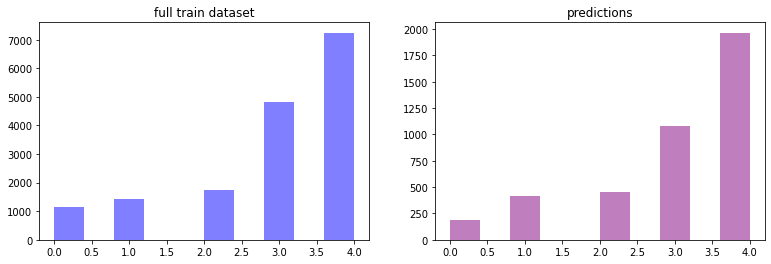

In [38]:
# Create a 3x1 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(13,4))

# Plot the first histogram in the first subplot
axs[0].hist(full_train_dataset['train']['label'], color='blue', alpha=0.5)
axs[0].set_title('full train dataset')

# Plot the fourth histogram in the fourth subplot
axs[1].hist(test_predictions, color='purple', alpha=0.5)
axs[1].set_title('predictions')

plt.show()

# End comet experiment

In [39]:
# experiment.end()

# Logs from Comet ML

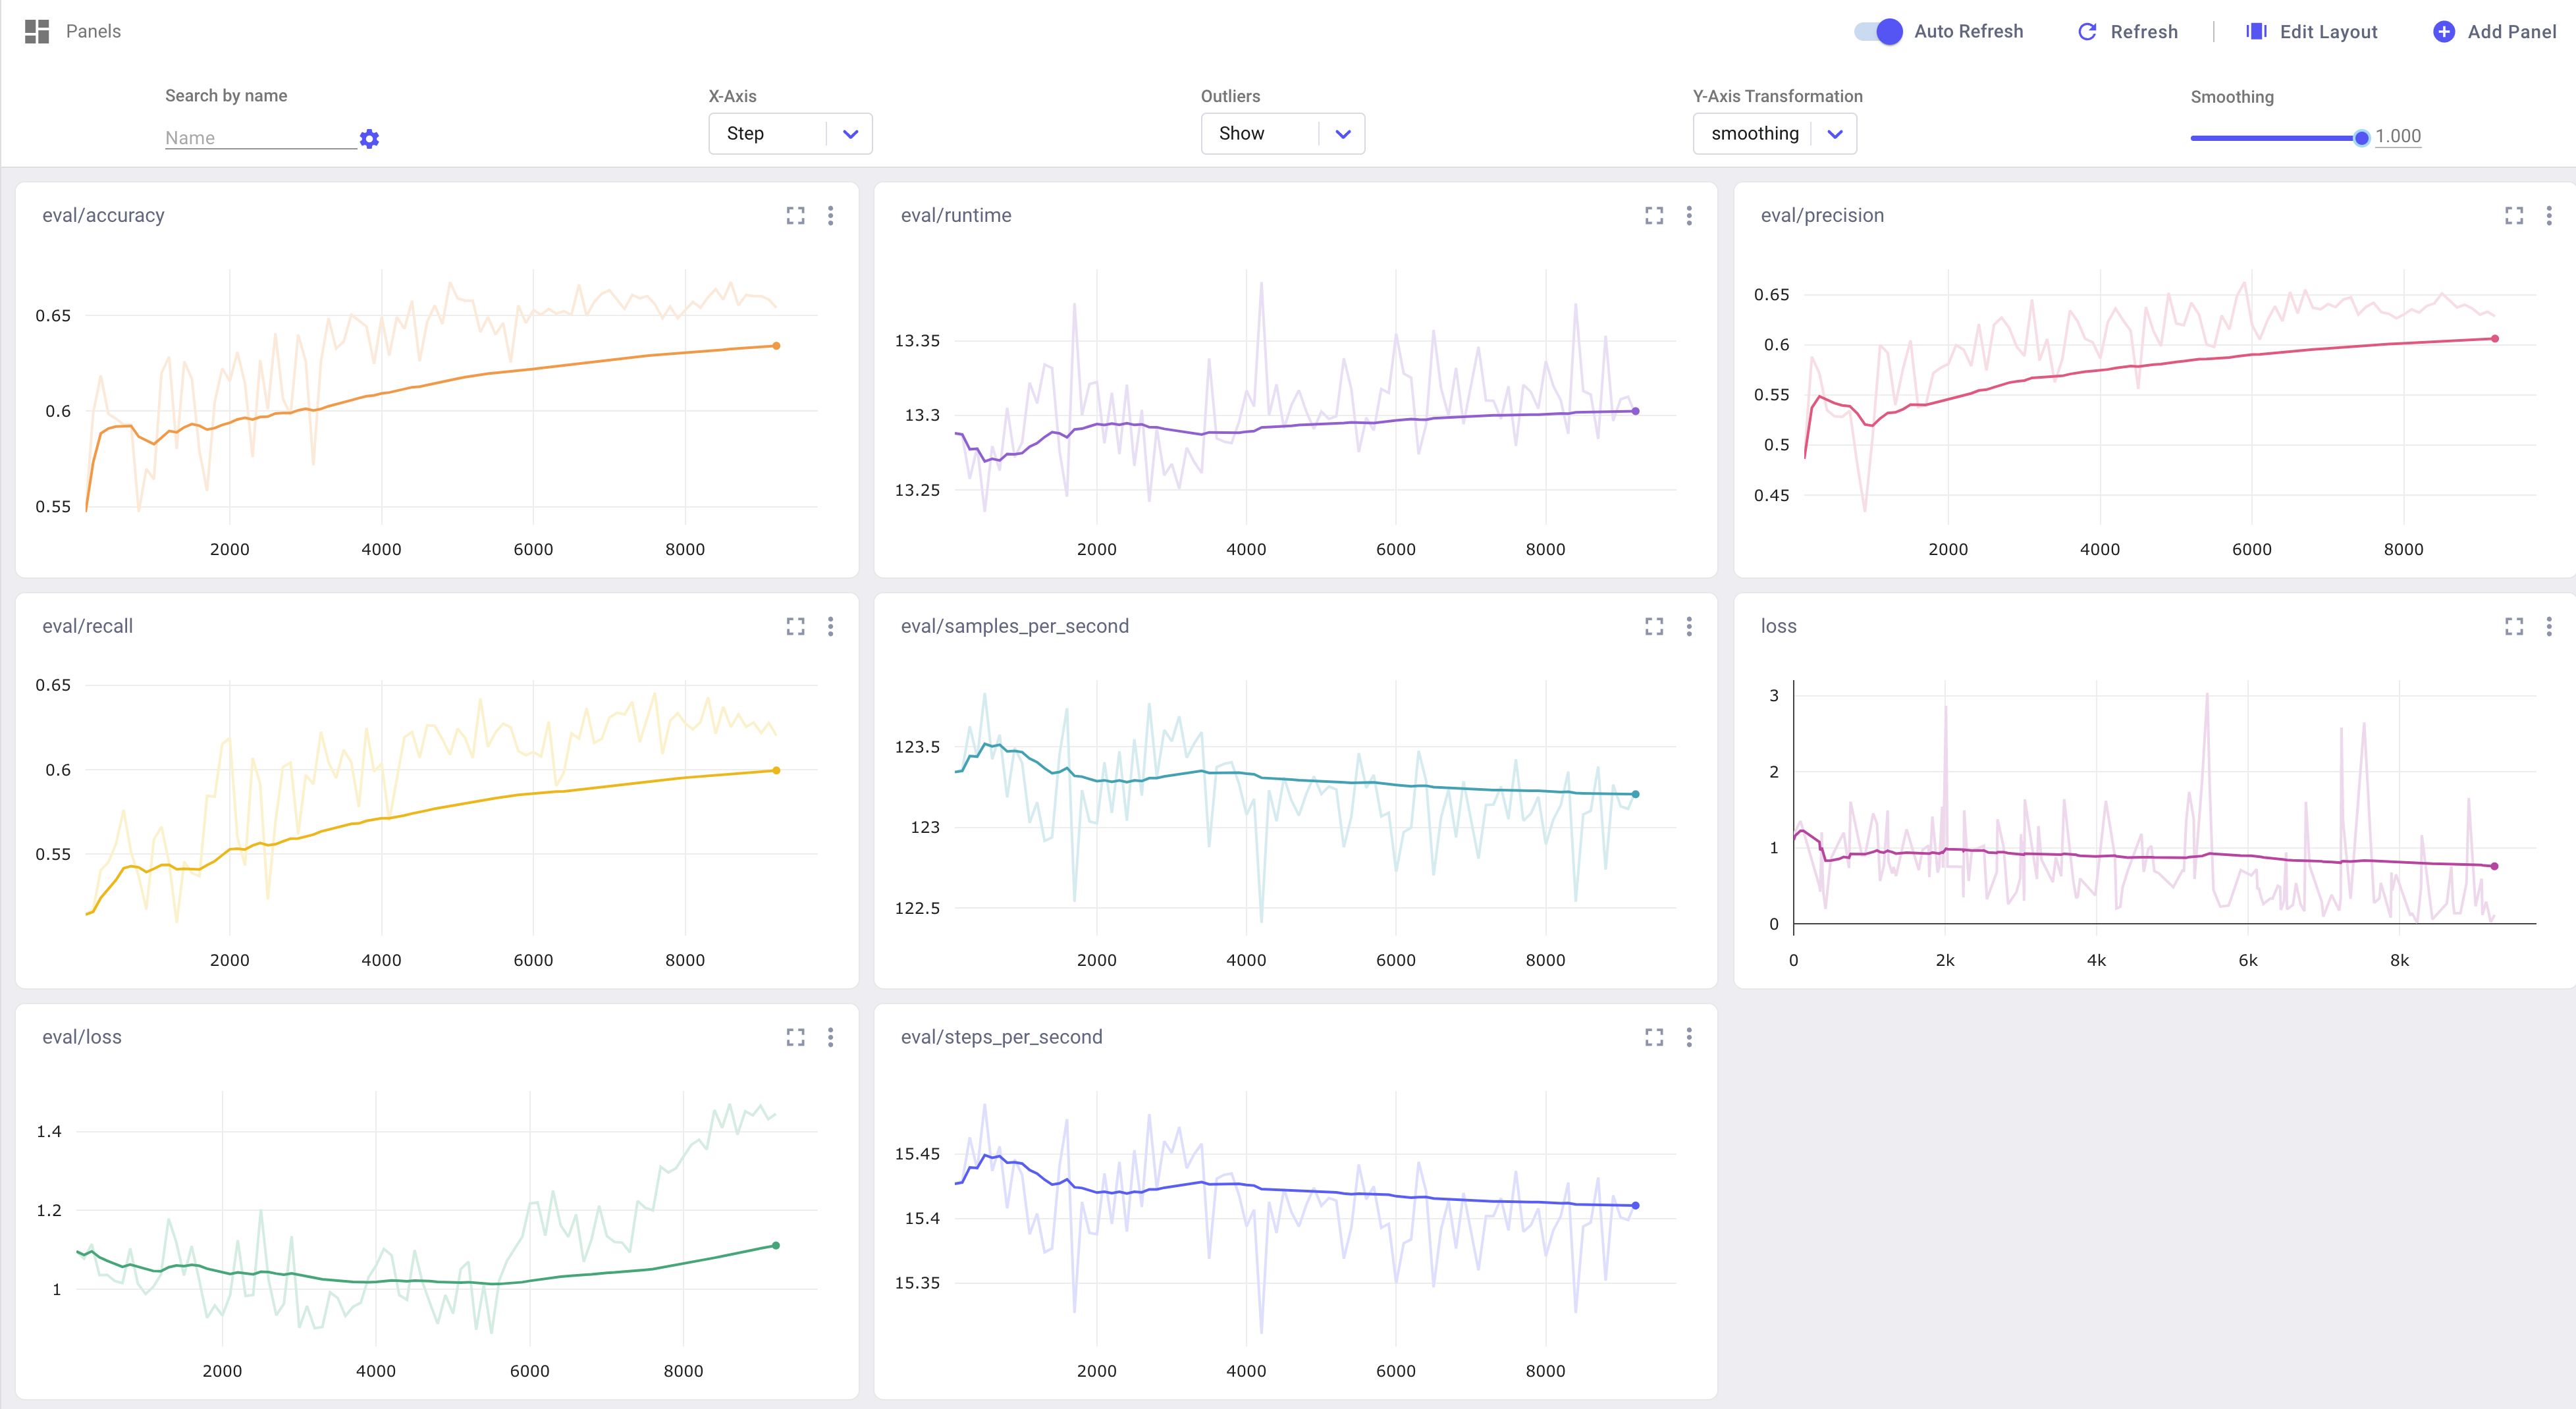

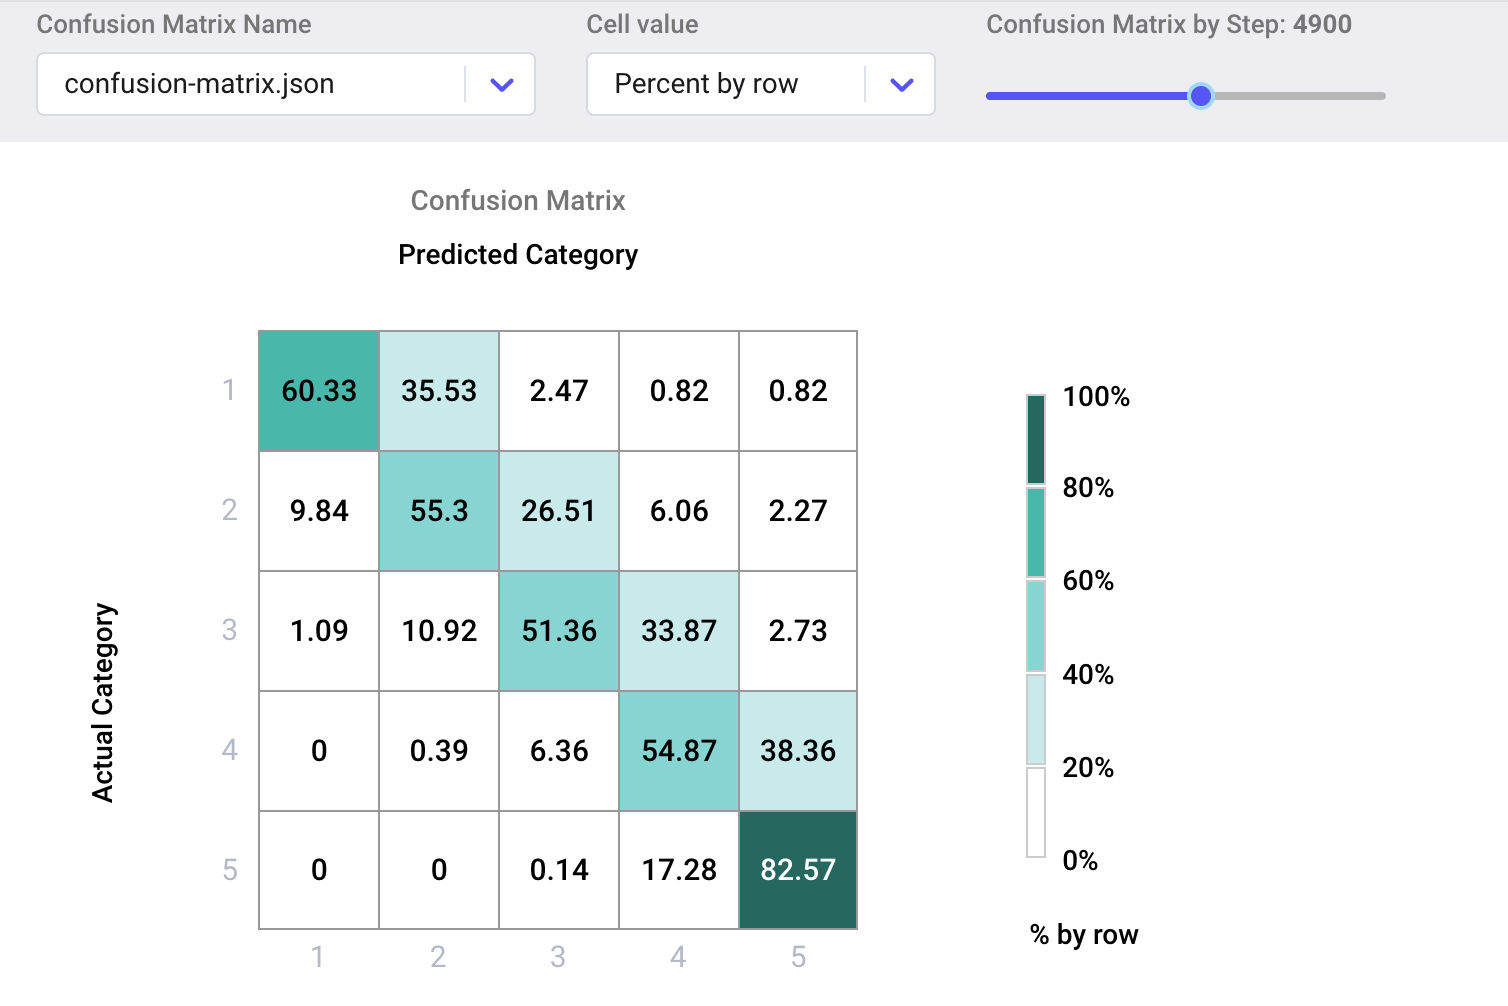